In [ ]:
# Linear Regression (tech)

Average cross-validation MSE: 0.0000
Average testing MSE: 0.0000
Directional Accuracy: 0.9968


C:\Users\fanqi\AppData\Local\Temp\ipykernel_14544\1638264966.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['Label'] = np.sign(actual_data['Price Change'])


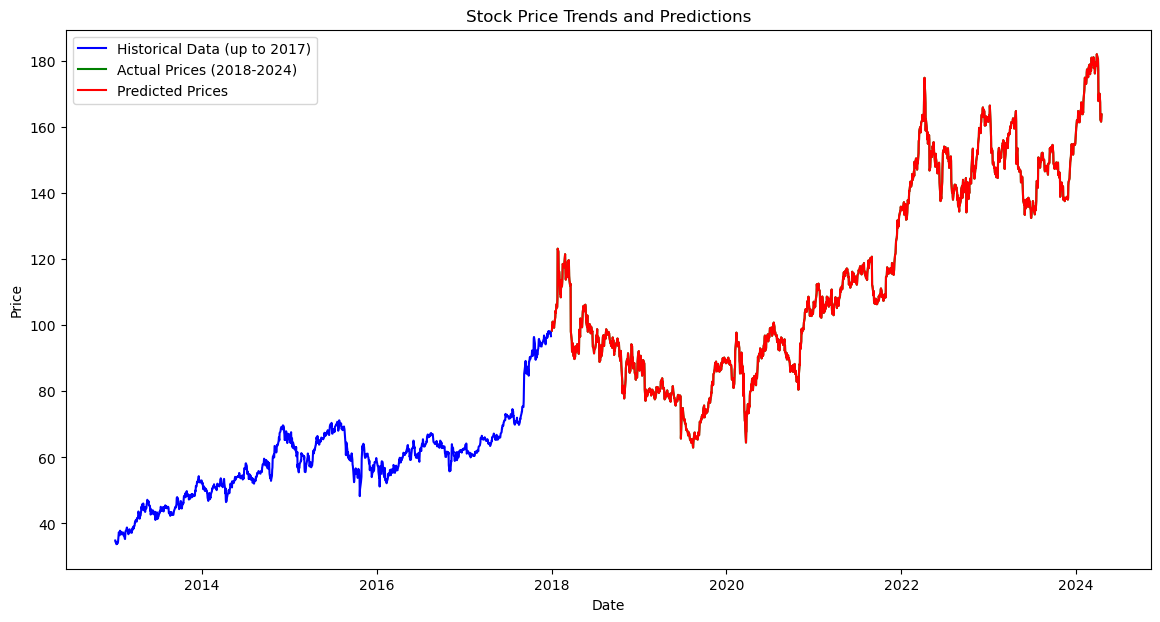

In [20]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import matplotlib.pyplot as plt

def preprocess_data(file_path, end_date=None):
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    if end_date:
        data = data[data['Date'] <= pd.to_datetime(end_date)]
    data['Prev Close'] = data['Close'].shift(1)
    data['Price Change'] = (data['Close'] - data['Prev Close']) / data['Prev Close']
    data.dropna(inplace=True)
    return data

directory_path = './new_data/healthcare'

model = LinearRegression()
scaler = StandardScaler()
cv_scores = []
test_scores = []

for file in os.listdir(directory_path):
    if file.endswith('.csv'):
        file_path = os.path.join(directory_path, file)
        data = preprocess_data(file_path, end_date='2017-12-31')
        X = data.drop(['Date'], axis=1)
        y = data['Price Change']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        cv_score = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='neg_mean_squared_error')
        cv_scores.extend(-cv_score)

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        test_scores.append(mse)

avg_cv_mse = np.mean(cv_scores)
avg_mse = np.mean(test_scores)
print(f"Average cross-validation MSE: {avg_cv_mse:.4f}")
print(f"Average testing MSE: {avg_mse:.4f}")

testing_file_path = './new_data/healthcare/ABBV.csv'
testing_data = preprocess_data(testing_file_path)
historical_data = testing_data[testing_data['Date'] <= pd.to_datetime('2017-12-31')]
actual_data = testing_data[testing_data['Date'] >= pd.to_datetime('2018-01-01')]
actual_data['Label'] = np.sign(actual_data['Price Change'])
X_actual = scaler.transform(actual_data.drop(['Date', 'Label'], axis=1))
predictions = model.predict(X_actual)
predicted_directions = np.sign(predictions)
acc = accuracy_score(actual_data['Label'], predicted_directions)
print(f"Directional Accuracy: {acc:.4f}")


plt.figure(figsize=(14, 7))
plt.plot(historical_data['Date'], historical_data['Close'], label='Historical Data (up to 2017)', color='blue')
plt.plot(actual_data['Date'], actual_data['Close'], label='Actual Prices (2018-2024)', color='green')
predicted_changes = predictions
predicted_prices = actual_data['Prev Close'] * (1 + predicted_changes)
plt.plot(actual_data['Date'], predicted_prices, label='Predicted Prices', color='red')
plt.title('Stock Price Trends and Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()